This notebook contains code for a change point detection algorithm that has been adapted from CUSUM.

Given a time series data $\{ X_i \}^{\infty}_{i=1}$, the tracking statistics used in CUSUM is given by:

$$ S^{+}_i = max \{0, S^{+}_{i-1} + X_i - (\mu_X + k\sigma)\} \quad\quad S^{+}_0 = 0 $$
$$ S^{-}_i = max \{0, S^{-}_{i-1} + \mu_X - (X_i + k\sigma)\} \quad \quad S^{-}_0 = 0 $$

$ \text{Where k is a scalar} $

To detect rising edges of a rectangular signal the algorithm was modified as follows:

$$ S^{+}_i = max \{0, S^{+}_{i-1} + X_{i+1} - (X_i + k\sigma)\} \quad\quad S^{+}_0 = 0 $$

This algorithm has been used to process Time Domain Reflectometry (TDR) signals to extract time delay between incident and reflected signals to calculate distance to faults in cables.

The **cusum.py** module contain the functions used in this notebook

In [1]:
import os
import time
import cusum as cs
import numpy as np
import configparser
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('cusum-parameters.ini')

c = float(config['signal']['c']) #velocity of light
v_peak = int(config['signal']['v_peak']) #v_peak
st_dev = float(config['signal']['st_dev']) #standard deviation of the fast-rising rectangular pulse
pulse_freq = float(config['signal']['pulse_freq'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

a_vf = float(config['thresholds']['a_vf']) #approximate velocity factor for window size setting
rising_edge_k = int(config['thresholds']['rising_edge_k'])
reflection_edge_threshold = float(config['thresholds']['reflection_edge_threshold'])


vf = float(config['cable']['vf']) #cable velocity factor
c_len = int(config['cable']['c_len'])


win_size = int(((c_len * 2) / (a_vf * c)) * sampling_rate) #window size to search for change points
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

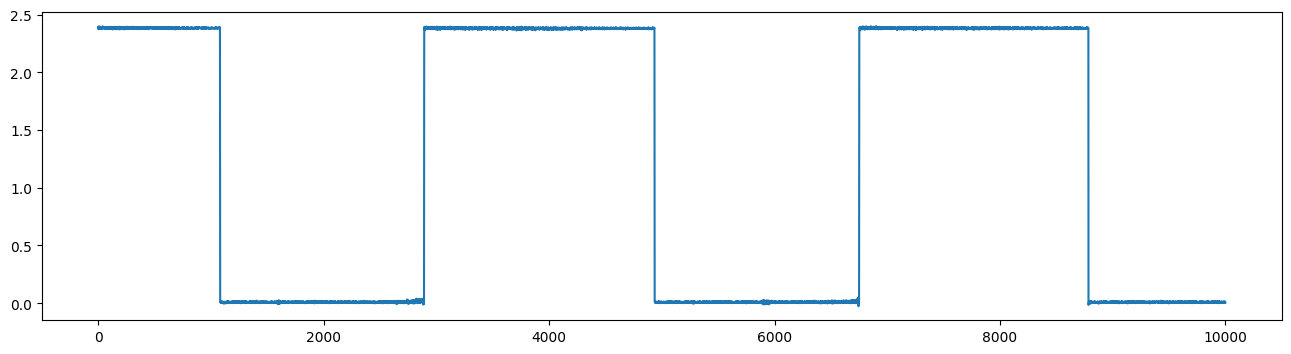

In [3]:
#load and plot a sample tdr signal
pulse = np.array(list(map(float, pd.read_csv('data/pulses/pulses-1.csv')['VC mem handle 5'].tolist()[1:-1])))

plt.figure(figsize=(16,4))
plt.plot(pulse)
plt.show()

In [4]:
#load the excel file conataining paths to the signals 
files_paths = pd.concat(pd.read_excel('files-paths.xlsx', sheet_name=None, skiprows=0).values(), ignore_index=True)['paths'].tolist()

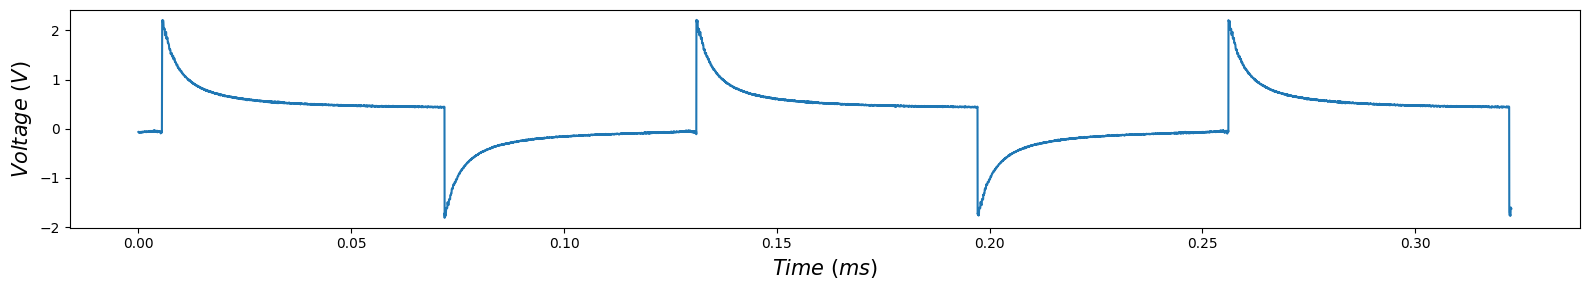

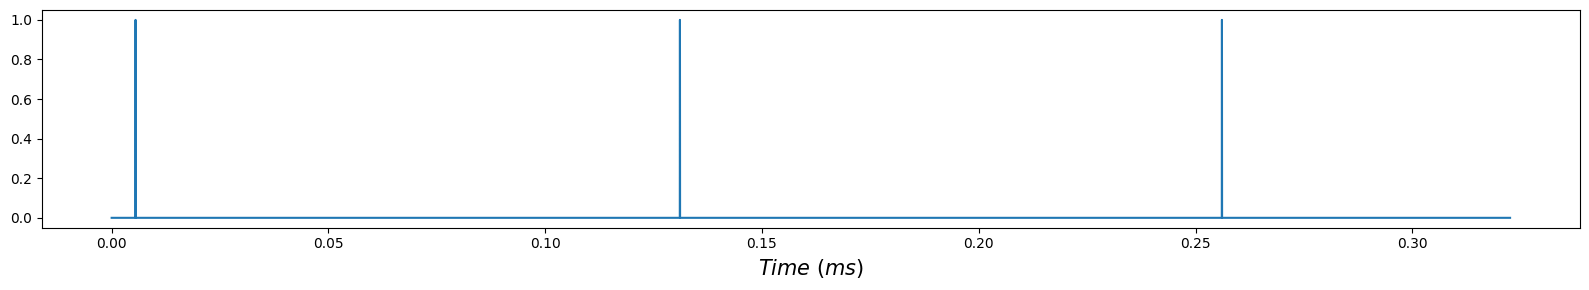

In [5]:
#load a random file and extract edges
sig = cs.random_file_load(files_paths, num_samples, v_peak)
edges, e_indices = cs.rising_edge(sig, st_dev, pulse_freq, duty_cycle, sampling_rate, rising_edge_k, num_samples, win_size)
cs.edges_plot(t, sig, edges)

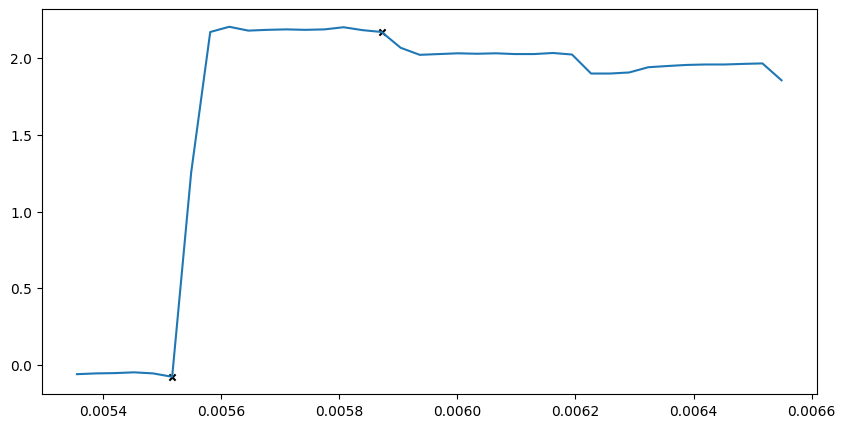

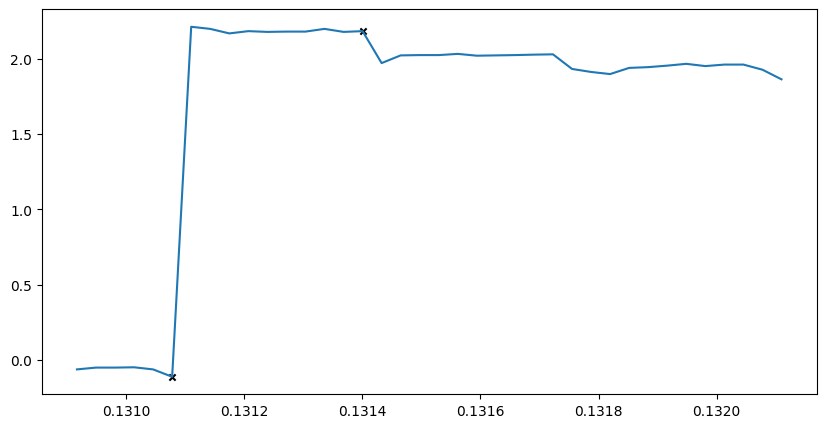

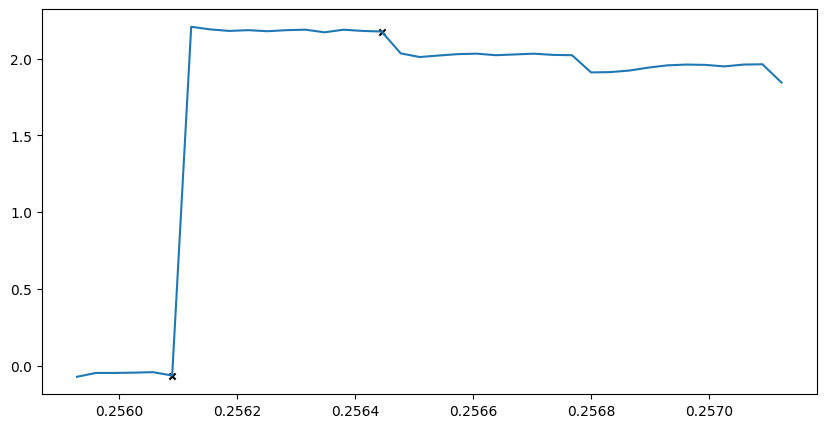

In [6]:
cp_indices, segs_interest = cs.changepoint(sig, 106, e_indices, sampling_rate, c, a_vf, win_size, reflection_edge_threshold)
cs.cp_plot(t, sig, segs_interest)

In [7]:
t_delays, avg_t_delay = cs.time_delay(t, segs_interest)
print(t_delays, avg_t_delay)

fault_point_dist = cs.fault_point(avg_t_delay, c, vf)
print(fault_point_dist)

[0.00035487419709712923, 0.0003226129064519412, 0.0003548741970971214] 0.0003441204335487306
50.51343844061817


In [10]:
f_paths = []
e_values = [] #expected distance values
p_values = [] #predicted distance values
avg_time_delay = []
excel_file = 'files-paths.xlsx'
xls = pd.ExcelFile(excel_file)
start_time = time.monotonic()
for name in xls.sheet_names:
    paths = pd.read_excel(excel_file, sheet_name=name)['paths'].tolist()
    
    for path in paths:
        sig = cs.file_loader(path) #load the file
        valid_file = cs.file_validity(sig, num_samples, v_peak) #check if there was a bus conflict while saving the file

        if valid_file:
            _, e_indices = cs.rising_edge(sig, st_dev, pulse_freq, duty_cycle, sampling_rate, rising_edge_k, num_samples, win_size)
            _, segs_interest = cs.changepoint(sig, 106, e_indices, sampling_rate, c, a_vf, win_size, reflection_edge_threshold)
            _, avg_t_delay = cs.time_delay(t, segs_interest)
            fault_point_dist = cs.fault_point(avg_t_delay, c, vf)

            p_values.append(fault_point_dist)
            e_values.append(float(name))
            
end_time = time.monotonic()
print('Runtime: ', timedelta(seconds=end_time - start_time))

Runtime:  0:00:03.594000


In [9]:
#model performance
performance = cs.performance_metrics(e_values, p_values)
print('Model performance for all faults:', performance)

Model performance for all faults: Metrics(mse=4.28095820672952, rmse=2.0690476569498153, mae=1.7501926406064703, irm=0.9975550122249389)
